# TextClassifier Usage

This usage provides instructions on how to use the `TextClassifier` class from the `hyfiml.models` module for text classification tasks.

## Installation

You can install the `hyfiml` package using pip:

```bash
pip install hyfiml
```

## Usage

### Step 1: Import the necessary modules


In [1]:
from hyfiml import HyFI
from hyfiml.models import (
    CrossValidateConfig,
    DatasetConfig,
    TextClassifier,
    TrainingConfig,
)

/home/yjlee/.venvs/hyfi-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 2: Initialize the HyFI project


In [2]:
if HyFI.is_colab():
    HyFI.mount_google_drive()

h = HyFI.initialize(
    project_name="hyfi-ml",
    project_root=".",
    logging_level="INFO",
    verbose=True,
)

print("project_dir:", h.project.root_dir)
print("project_workspace_dir:", h.project.workspace_dir)


INFO:hyfi.utils.notebooks:Google Colab not detected.
INFO:hyfi.utils.notebooks:Extension autotime not found. Install it first.
INFO:hyfi.joblib.joblib:initialized batcher with <hyfi.joblib.batcher.batcher.Batcher object at 0x7fb0eda57d30>
INFO:hyfi.main.config:HyFi project [hyfi-ml] initialized


project_dir: /raid/data/yjlee/workspace/projects/hyfi-ml/book/usage
project_workspace_dir: /raid/data/yjlee/workspace/projects/hyfi-ml/book/usage/workspace


This step initializes the HyFI project and sets up the project directory and workspace directory.

### Step 3: Load and preprocess the dataset


In [3]:
data_dir = h.project.workspace_dir
raw_data = HyFI.load_dataframe("cointax.csv", data_dir)
raw_data.info()

import numpy as np

data = []
for polarity, rows in raw_data.to_dict().items():
    data += [
        dict(text=text, label="positive" if polarity == "긍정" else "negative")
        for text in rows.values()
        if text is not np.NaN and len(text) > 3
    ]

data = HyFI.records_to_dataframe(data)
data_file = str(data_dir / "cointax_data.parquet")
HyFI.save_dataframes(data, data_file)
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   긍정      478 non-null    object
 1   부정      236 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB


INFO:hyfi.utils.datasets.save:Saving dataframe to /raid/data/yjlee/workspace/projects/hyfi-ml/book/usage/workspace/cointax_data.parquet


,text,label
680,소득과세가 너누 높다,negative
681,주식 거래세 수수료보다도 너무 높다고 생각하기에,negative
682,너무 심하다고 생각,negative
683,......,negative
684,수익의 20%는 너무 많다고 생각한다,negative


This step loads the raw data from a CSV file, preprocesses it by extracting the text and labels, and saves the processed data as a Parquet file.

### Step 4: Create configurations for the TextClassifier


In [4]:
dataset_config = DatasetConfig(
    dataset_name="parquet",
    data_files=data_file,
    train_split_name="train",
    test_split_name="test",
    text_column_name="text",
    label_column_name="label",
    load_data_split="train",
    test_size=0.2,
    dev_size=None,
    stratify_on=None,
    random_state=None,
    id2label={0: "negative", 1: "positive"},
)

training_config = TrainingConfig(
    output_dir="output",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

cross_validate_config = CrossValidateConfig(
    n_splits=5,
    validation_size=0.1,
    random_state=42,
    shuffle=True,
)

This step creates instances of `DatasetConfig`, `TrainingConfig`, and `CrossValidateConfig` to configure the dataset, training, and cross-validation settings for the `TextClassifier`.

### Step 5: Create an instance of TextClassifier


In [5]:
classifier = TextClassifier(
    model_name="entelecheia/ekonbert-base",
    dataset_config=dataset_config,
    training_config=training_config,
    cross_validate_config=cross_validate_config,
)


This step creates an instance of the `TextClassifier` class with the specified configurations.

### Step 6: Load the dataset and train the model


In [6]:
dataset = classifier.load_dataset()
train_test_datasets = classifier.split_dataset(dataset)
train_dataset = train_test_datasets["train"]
classifier.train(train_dataset)

Generating train split: 685 examples [00:00, 330811.54 examples/s]
Map: 100%|██████████| 548/548 [00:00<00:00, 137732.42 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.596100,0.556980,0.690909
2,0.430000,0.470387,0.754545


This step loads the dataset using the `load_dataset` method of the `TextClassifier` and trains the model using the `train` method.

### Step 7: Make predictions on a new dataset


In [7]:
test_dataset = train_test_datasets["test"]
predictions = classifier.predict(test_dataset)
print(predictions)

Map: 100%|██████████| 137/137 [00:00<00:00, 31647.28 examples/s]


['positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'po

This step loads a new dataset and makes predictions using the trained `TextClassifier`.

### Step 8: Plot a confusion matrix


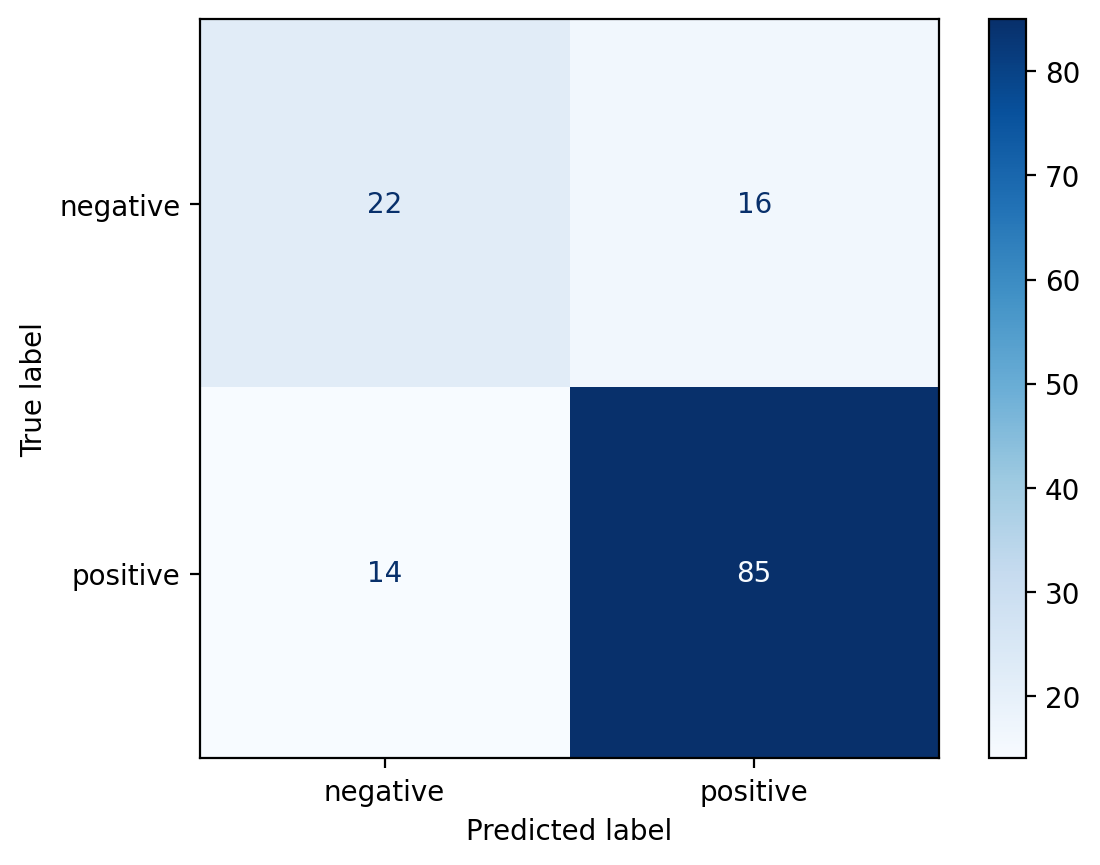

In [8]:
labels = ["negative", "positive"]
classifier.plot_confusion_matrix(test_dataset, labels)

This step plots a confusion matrix using the `plot_confusion_matrix` method of the `TextClassifier`. It takes the new dataset and a list of labels as arguments.


## Conclusion

This usage provided a step-by-step guide on how to use the `TextClassifier` class from the `hyfiml.models` module for text classification tasks. It covered initializing the HyFI project, loading and preprocessing the dataset, creating configurations for the `TextClassifier`, creating an instance of the `TextClassifier`, training the model, making predictions, and plotting a confusion matrix.
